In [66]:
using Trixi
using Plots
using DifferentialEquations
using OrdinaryDiffEq
using Printf

In [67]:
using Trixi: AbstractEquations, get_node_vars
import Trixi: varnames, default_analysis_integrals, flux, max_abs_speed_naive,
              have_nonconservative_terms

# Since there is no native support for variable coefficients, we use three
# variables: one for the basic unknown 'u' and two for the advection
# velocity: a_x and a_y
struct NonlinearAdvectionEquation <: AbstractEquations{2 #= spatial dimension =#,
                                                       3 #= three variables (u,a_x, a_y) =#}
end

# Give names to the variables
varnames(::typeof(cons2cons), ::NonlinearAdvectionEquation) = ("scalar", "a_x", "a_y")

# Use other analysis integrals
default_analysis_integrals(::NonlinearAdvectionEquation) = ()

# Redefine the value of the flux (the part inside the \nabla \cdot (...))
# for both dimensions
function flux(u, orientation, equation::NonlinearAdvectionEquation)
    if orientation == 1 # x-direction)
        f = SVector(u[1]*u[2], zero(eltype(u)), zero(eltype(u)))
    else orientation ==2 # y-direction
        f = SVector(u[1]*u[3], zero(eltype(u)), zero(eltype(u)))
    end
    return f
end

# Make sure that the equation is conservative (default value)
have_nonconservative_terms(::NonlinearAdvectionEquation) = Val(false)

# Calculate maximum wave speed for local Lax-Friedrichs-type dissipation
function max_abs_speed_naive(u_ll, u_rr, orientation::Integer, ::NonlinearAdvectionEquation)
    _, a_x_ll, a_y_ll = u_ll # unpack u_ll
    _, a_x_rr, a_y_rr = u_rr # unpack u_rr
    if orientation == 1 # x-direction
        f = max(abs(a_x_ll), abs(a_x_rr)) # return maximum x-velocity
    else orientation == 2 # y-direction
        f = max(abs(a_y_ll), abs(a_y_rr)) # return maximum y-velocity
    end
    return f # return the maximum speed in the direction of the orientation
end

max_abs_speed_naive (generic function with 31 methods)

In [68]:
function initial_condition(x, t, equation::NonlinearAdvectionEquation)
    if (-40 <= x[1] <= 40 ) & (-40 <= x[2] <= 40)
        u0 = 0.8
    else u0 = 0.0
    end
    
    u0 = 1*exp(-(x[1]^2/200 + x[2]^2/200))
    
    if (-80 <= x[1] <= -50 ) & (-40 <= x[2] <= 40)
        u0 = 0.5
    end
    return SVector(u0, 0.0, 0.0)
end

function boundary_condition_everywhere(x,t,equation::NonlinearAdvectionEquation)
    return SVector(0.0, 0.0, 0.0)
end


boundary_condition_everywhere (generic function with 1 method)

In [69]:
# Remember to pass a tuple of the form `(conservative_flux, nonconservative_flux)`
# as `surface_flux` and `volume_flux` when working with nonconservative terms
volume_flux  = flux_central
surface_flux = flux_lax_friedrichs
solver = DGSEM(polydeg=3, surface_flux=surface_flux,
               volume_integral=VolumeIntegralFluxDifferencing(volume_flux))

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralFluxDifferencing                                   │
│ │ volume flux: ………………………………………… flux_central                                                     │
└──────────────────────────────────────────────────────────────────────────────────────────

In [77]:
# Create a uniform mesh in 2D in the interval [-1, 1] x [-1, 1] with periodic boundaries
coordinates_min = (-100.0, -100.0)
coordinates_max = (100., 100.0)
mesh = TreeMesh(coordinates_min, coordinates_max, # min/max coordinates
                initial_refinement_level=4, n_cells_max=10000,
                periodicity = false)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TreeMesh{2, Trixi.SerialTree{2}}                                                                 │
│ ════════════════════════════════                                                                 │
│ center: …………………………………………………………… [0.0, 0.0]                                                       │
│ length: …………………………………………………………… 200.0                                                            │
│ periodicity: ……………………………………………… (false, false)                                                   │
│ current #cells: ……………………………………… 341                                                              │
│ maximum #cells: ……………………………………… 10000                                                            │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [194]:
# Set equation
equation = NonlinearAdvectionEquation()

#Periodic boundary conditions and initial condition
#boundary_conditions = boundary_condition_periodic
boundary_condition = boundary_condition_everywhere
boundary_conditions = (x_neg = BoundaryConditionDirichlet(boundary_condition),
                       x_pos = BoundaryConditionDirichlet(boundary_condition),
                       y_neg = BoundaryConditionDirichlet(boundary_condition),
                       y_pos = BoundaryConditionDirichlet(boundary_condition) )


initial_condition = initial_condition

semi = SemidiscretizationHyperbolic(mesh, equation, initial_condition, solver, 
                                    boundary_conditions=boundary_conditions)

# Create an ODE problem with given time span
tspan = (0.0, 100.)#
ode_baseline = semidiscretize(semi, tspan); # define the baseline ODE problem

In [195]:
# Create a function that modifies the left hand side of the equation
# Create a modfied rhs
function mu_x(x,y,t)
    return 1 + (x/100)^2
end

function mu_y(x,y,t)
    return 1 + (y/100)^2
end

function V(rho)
    #return 1-rho/2
    return exp(-rho/2)
end

function modified_rhs!(du_ode, u_ode, semi, t)
    u_sol = reinterpret(SVector{3, Float64}, vec(u_ode)) # set sol.u in a more useful form
    us = [elm[1] for elm in u_sol] # extract the density u
    x = reinterpret(SVector{2, Float64}, vec(semi.cache.elements.node_coordinates)) # get the (x,y) coordinates of the grid nodes

    x_sol = [elm[1] for elm in x]
    y_sol = [elm[2] for elm in x]    
    
    a = [SVector(0.0, 0.0) for elm in x]
    for i = 1:length(a)
        a_x = mu_x(x[i][1], x[i][2],t)
        a_y = mu_y(x[i][1], x[i][2],t)
        norm  = sqrt(a_x^2 + a_y^2)
        a_x = a_x/norm
        a_y = a_y/norm
        a[i] = SVector(a_x, a_y)
    end

    ax = [elm[1] for elm in a] # extract the x-components a_x from a
    ay = [elm[2] for elm in a] # extract the y-components a_x from a    
    ax = ax .* [V(elm) for elm in us]
    ay = ay .* [V(elm) for elm in us]
    u_sol = [SVector(us[i], ax[i], ay[i]) for i in 1:length(us)] # redefine sol.u
    u_sol = reinterpret(SVector{1, Float64}, u_sol) # convert it back to its old form
    u_odenew = [u[1] for u in u_sol] # and make it of the correct shape
    Trixi.rhs!(du_ode, u_odenew, semi, t) # update Trixi.rhs! to make the problem  work
end

# define the ODE problem which should be solved
ode = ODEProblem(modified_rhs!, ode_baseline.u0, ode_baseline.tspan, ode_baseline.p #= = semi =#); 

In [196]:
# Define functions which respectively save or show the plots (inline)
# Save the plots
function save_plot(plot_data, variable_names;
                   show_mesh=true, plot_arguments=Dict{Symbol,Any}(),
                   time=nothing, timestep=nothing)
  # Gather subplots
  plots = []
  for v in variable_names
    push!(plots, Plots.plot(plot_data[v]; plot_arguments...))
  end
  if show_mesh
    push!(plots, Plots.plot(getmesh(plot_data); plot_arguments...))
  end
  # Determine layout
  cols = ceil(Int, sqrt(length(plots)))
  rows = div(length(plots), cols, RoundUp)
  layout = (rows, cols)
  # Create plot
  Plots.plot(plots..., layout=layout)
  # Determine filename and save plot
  filename = joinpath("out-images", @sprintf("solution_%06d.png", timestep))
  Plots.savefig(filename)
end;

# Show the plots
function show_plot(plot_data, variable_names;
                   show_mesh=true, plot_arguments=Dict{Symbol,Any}(),
                   time=nothing, timestep=nothing)
  # Gather subplots
  plots = []
  for v in variable_names
    push!(plots, Plots.plot(plot_data[v]; plot_arguments...))
  end
  if show_mesh
    push!(plots, Plots.plot(getmesh(plot_data); plot_arguments...))
  end
    # Determine layout
  cols = ceil(Int, sqrt(length(plots)))
  rows = div(length(plots), cols, RoundUp)
  layout = (rows, cols)

  # Show plot
  display(Plots.plot(plots..., layout=layout))
end;

In [197]:
# gives a summary after the simulation
summary_callback = SummaryCallback();

# prints an analysis of the results every given interval
analysis_callback = AnalysisCallback(semi, interval=50);

# visualizes the results during the simulation
visualization_callback = VisualizationCallback(; interval=0,
                        solution_variables=cons2cons,
                        variable_names=["scalar"],
                        show_mesh=false,
                        plot_data_creator=PlotData2D,
                        plot_creator = save_plot,
                        title = "Density", #title of the plots
                        clim = (0.0, 2.0)) # limits of the heat map

# saves the solutions every given interval
savesolution_callback = SaveSolutionCallback(;
                            interval=1, 
                            save_initial_solution=true, 
                            save_final_solution=true, 
                            output_directory="out-images",
                            solution_variables=cons2cons)

# computes the step size such that the cfl is fixed at given value
stepsize_callback = StepsizeCallback(; cfl=0.5)

# set which callbacks you want to use
callbacks = CallbackSet(summary_callback, stepsize_callback, visualization_callback);

In [198]:
# OrdinaryDiffEq's solve method evolves the solution in time and executes
# the passed callbacks
alg = AutoTsit5(Rosenbrock23()) # RK5/4 method
#alg = Midpoint() # uses Tsit5 or Rosenbock in case of stiffness
#alg = Midpoint() # 

# solve the problem using algorithm hints 
sol = solve(ode, alg, dt=1e-3, abstol=1.0e-6, reltol=1.0e-6,
            save_everystep=true, callback=callbacks);

# Print the timer summary
summary_callback();


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 341                 │
│ equations: …………………………………………………… NonlinearAdvectionEquation                                       │
│ initial condition: ……………………………… initial_condition                                                │
│ boundary conditions: ………………………… 4                                                                

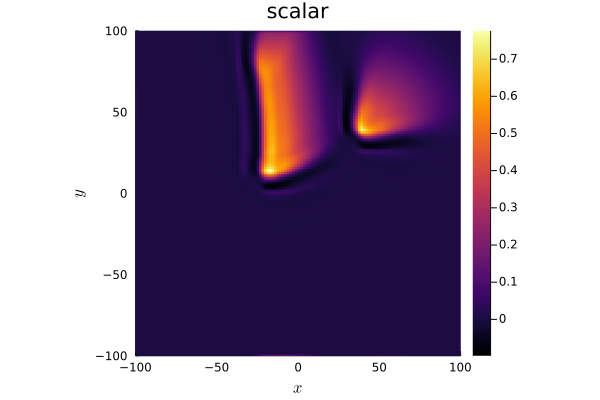

In [215]:
pd1 = PlotData2D(sol.u[end], semi)
plot(pd1["scalar"])

In [200]:
function advection_vel(x, us, t)

    x_sol = [elm[1] for elm in x]
    y_sol = [elm[2] for elm in x]
    
    a = [SVector(0.0, 0.0) for elm in x]

    for i = 1:length(a)
        a_x = mu_x(x_sol[i], y_sol[i], t)
        a_y = mu_y(x_sol[i], y_sol[i], t)
        
        norm = sqrt(a_x^2 + a_y^2) 
        
        a_x = a_x/norm
        a_y = a_y/norm
    
        
        a[i] = SVector(a_x, a_y)
    end    
    
    return a
end

# Create a modfied rhs
function return_good_solution(sol)
    for i in 1:length(sol.u)
        u_sol = reinterpret(SVector{3, Float64}, vec(sol.u[i]))
        us = [elm[1] for elm in u_sol]
        x = reinterpret(SVector{2, Float64}, vec(semi.cache.elements.node_coordinates))
        a = advection_vel(x, us, sol.t[i])
        ax = [elm[1] for elm in a]
        ay = [elm[2] for elm in a]
        ax = ax .* [V(elm) for elm in us]
        ay = ay .* [V(elm) for elm in us]
        u_sol = [SVector(us[i], ax[i], ay[i]) for i in 1:length(us)]
        u_sol = reinterpret(SVector{1, Float64}, u_sol)
        u_odenew = [u[1] for u in u_sol]
        sol.u[i] = u_odenew
    end
end



return_good_solution (generic function with 1 method)

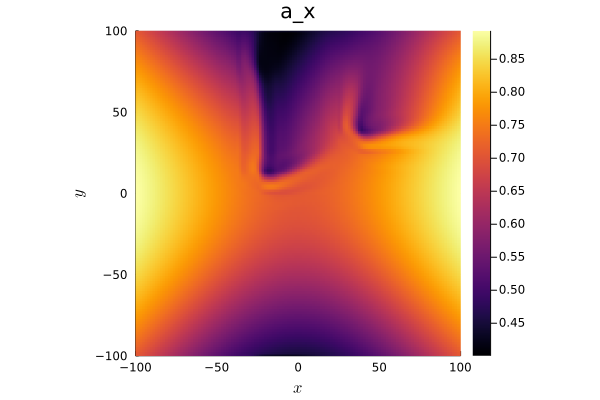

In [220]:
pd = PlotData2D(sol.u[end], semi)
display(plot(pd["a_x"]))
time = tspan[end]
filename = joinpath("Figures_report", "t=" * string(time) * "+velocity_field_v4" * ".png")
savefig(filename)

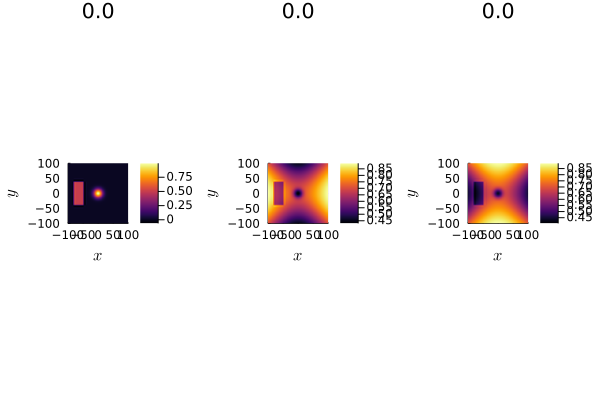

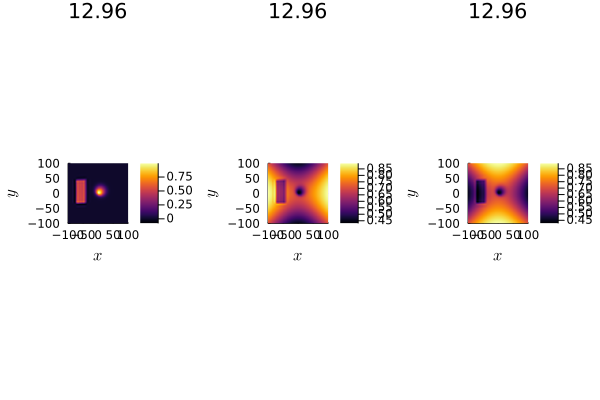

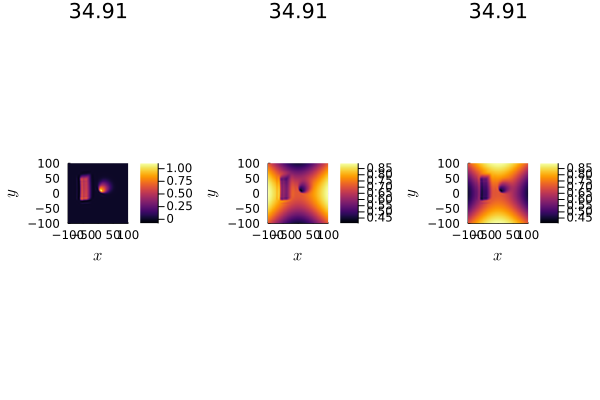

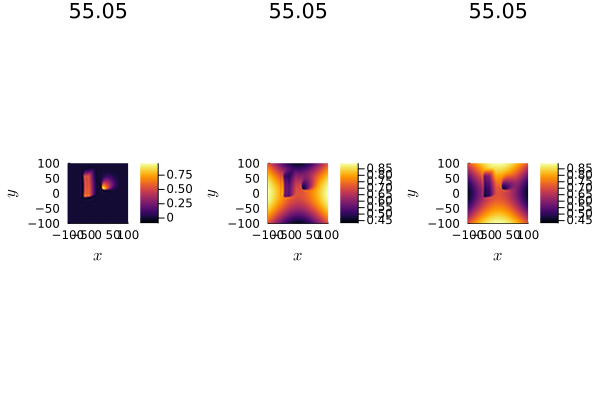

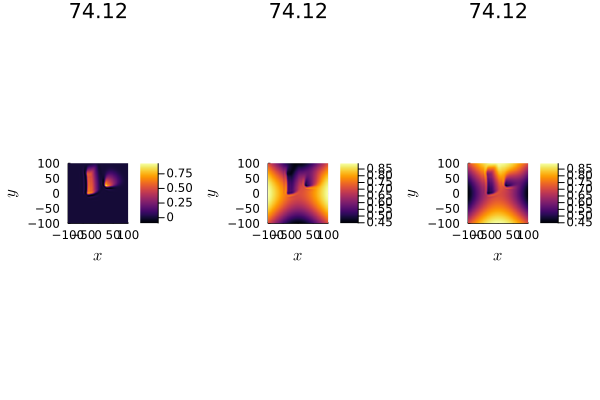

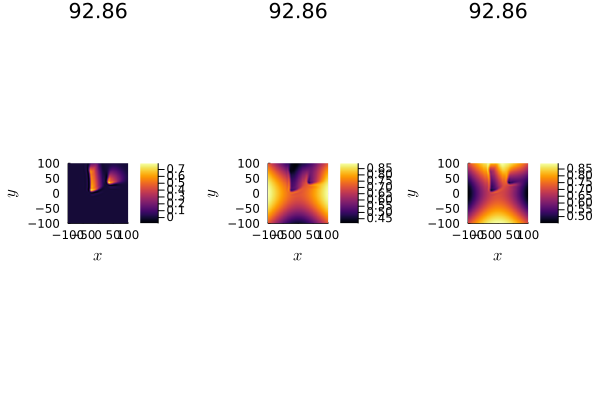

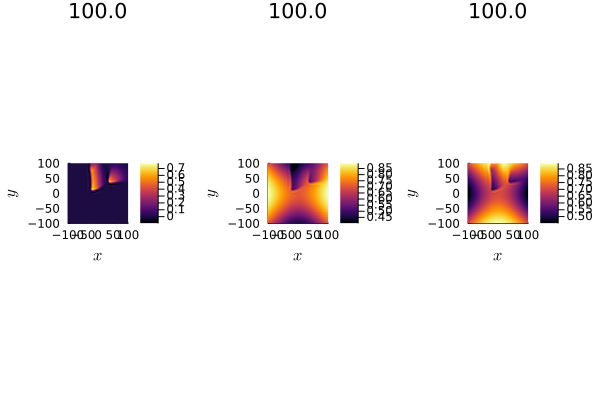

In [208]:
return_good_solution(sol) # modify the solution to the correct form
for t in 1:20:length(sol.t)
    display(Plots.plot(sol.u[t], semi, title=round(sol.t[t], digits=2)))
end

p = Plots.plot(sol.u[end], semi, title=round(sol.t[end], digits=2))

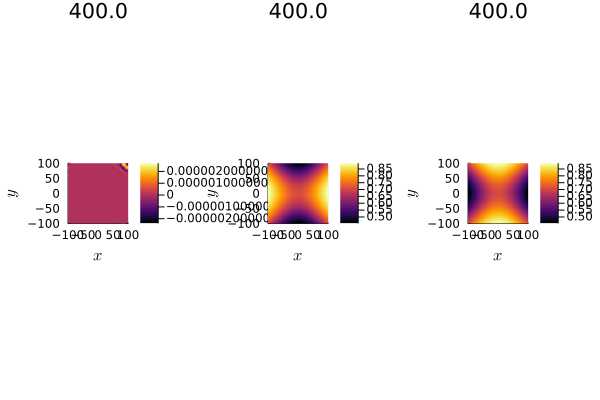

In [14]:
display(Plots.plot(sol.u[end], semi, title=round(sol.t[end], digits=2)))

In [173]:
using LaTeXStrings
x = LinRange(0,2, 100)
y1 = exp.(- x ./ 2)
y2 = (1 .- x ./ 2)
plot(x, y1, label=L"V_1(\rho)")
plot!(x,y2, label=L"V_2(\rho)")
xlabel!(L"\rho")
ylabel!(L"V(\rho)")

savefig("Figures_report\\speed_functions.png")

In [172]:
filename

"Figures_report\\t=100.0+v4.png"

In [214]:
typeof(p)

Plots.Plot{Plots.GRBackend}